# pytorch-yolo2

ref: https://github.com/longcw/yolo2-pytorch

### get model

In [ ]:
from darknet import Darknet

In [ ]:
cfgfile =  './cfg/yolo-pose.cfg' 
weightfile =  './backup/cargo/model_backup.weights'
weightfile2 =  './backup/cargo/model.weights'

In [ ]:
m = Darknet(cfgfile)
m2 = Darknet(cfgfile)
m.load_weights(weightfile)
m2.load_weights(weightfile2)
print('Loading weights from %s... Done!' % (weightfile))
print('Loading weights from %s... Done!' % (weightfile2))

### save detection information

In [ ]:
import pickle
op_dict = {
    'num_classes':m.num_classes,
    'anchors':m.anchors,
    'num_anchors':m.num_anchors
}
pickle.dump(op_dict, open('detection_information.pkl','wb'))

# use Onnx to convert model

ref: https://github.com/onnx/tutorials/blob/master/tutorials/PytorchOnnxExport.ipynb

In [ ]:
import torch.onnx
from torch.autograd import Variable

# Standard ImageNet input - 3 channels, 224x224,
# values don't matter as we care about network structure.
# But they can also be real inputs.
dummy_input = Variable(torch.randn(1, 3, 416, 416))
# Obtain your model, it can be also constructed in your script explicitly
model = m
model2 = m2
# Invoke export
torch.onnx.export(model, dummy_input, "cargo_yolo2.onnx")
torch.onnx.export(model2, dummy_input, "cargo_yolo2_v2.onnx")

# Build TensorRT engine and serialize it

In [1]:
import cv2
import numpy as np
from numpy import array

import pycuda.driver as cuda
import pycuda.autoinit

import tensorrt as trt

import sys, os
sys.path.insert(1, os.path.join(sys.path[0], ".."))
import common

# You can set the logger severity higher to suppress messages (or lower to display more messages).
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def get_engine(onnx_file_path, engine_file_path=""):
    """Attempts to load a serialized engine if available, otherwise builds a new TensorRT engine and saves it."""
    def build_engine():
        """Takes an ONNX file and creates a TensorRT engine to run inference with"""
        with trt.Builder(TRT_LOGGER) as builder, builder.create_network() as network, trt.OnnxParser(network, TRT_LOGGER) as parser:
            builder.max_workspace_size = 1 << 30 # 1GB
            builder.max_batch_size = 1
            # Parse model file
            if not os.path.exists(onnx_file_path):
                print('ONNX file {} not found, please run yolov3_to_onnx.py first to generate it.'.format(onnx_file_path))
                exit(0)
            print('Loading ONNX file from path {}...'.format(onnx_file_path))
            with open(onnx_file_path, 'rb') as model:
                print('Beginning ONNX file parsing')
                parser.parse(model.read())
            print('Completed parsing of ONNX file')
            print('Building an engine from file {}; this may take a while...'.format(onnx_file_path))
            engine = builder.build_cuda_engine(network)
            print("Completed creating Engine")
            with open(engine_file_path, "wb") as f:
                f.write(engine.serialize())
            return engine

    if os.path.exists(engine_file_path):
        # If a serialized engine exists, use it instead of building an engine.
        print("Reading engine from file {}".format(engine_file_path))
        with open(engine_file_path, "rb") as f, trt.Runtime(TRT_LOGGER) as runtime:
            return runtime.deserialize_cuda_engine(f.read())
    else:
        return build_engine()

In [4]:
# Try to load a previously generated yolo network graph in ONNX format:
onnx_file_path = './cargo_yolo2.onnx'
onnx_file_v2_path = './cargo_yolo2_v2.onnx'
engine_file_path = './cargo_yolo2.trt'
engine_file_v2_path = './cargo_yolo2_v2.trt'
input_image_path = './cargo_sample.jpg'

In [5]:
def preprosess_img(img_path):
    frame = cv2.imread(img_path,0)
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    yolo_img =cv2.resize(img, (416, 416), interpolation=cv2.INTER_AREA)
    plt.imshow(img)
    return yolo_img

Reading engine from file ./cargo_yolo2_v2.trt
<class 'tensorrt.tensorrt.ICudaEngine'>
Running inference on image ./cargo_sample.jpg...
[array([        -inf,         -inf,         -inf, ..., -250.57047  ,
       -136.78687  ,   -2.5162568], dtype=float32)]
<class 'list'>


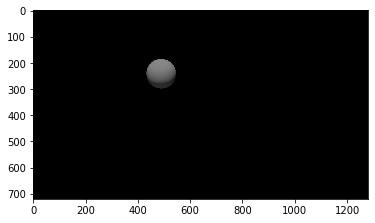

In [6]:
# Do inference with TensorRT
trt_outputs = []
with get_engine(onnx_file_v2_path, engine_file_v2_path) as engine, engine.create_execution_context() as context:
    inputs, outputs, bindings, stream = common.allocate_buffers(engine)
    print(type(engine))
    img = preprosess_img(input_image_path)
    # Do inference
    print('Running inference on image {}...'.format(input_image_path))
    # Set host input to the image. The common.do_inference function will copy the input to the GPU before executing.
    inputs[0].host = img
    trt_outputs = common.do_inference(context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)
    print(trt_outputs)
    print(type(trt_outputs))

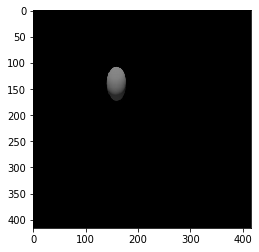

In [7]:
plt.imshow(img)

In [8]:
output_shapes = [(1,20,13,13)]
#trt_outputs = [output.reshape(shape) for output, shape in zip(trt_outputs, output_shapes)]
trt_outputs = array(trt_outputs).reshape(1,20,13,13)
# print('trt_outputs type', type(trt_outputs))

In [10]:
print('trt outputs shape ', trt_outputs.shape)

trt outputs shape  (1, 20, 13, 13)
